# OpenVINO Training Notebook
## Why Is OpenVINO Important?
OpenVINO accelerates time to market & ease of deployment for AR / ML applications by providing a set of functions and interfaces to easily quantize, optimize and run inference on ML models. It does so quickly and easily while being compatible with all the major frameworks and supporting optimized execution on intel hardware.
This is important to us because it makes leveraging Intel hardware easy for developer & allows customers to build better products on Intel.

## How Does OpenVINO Work?
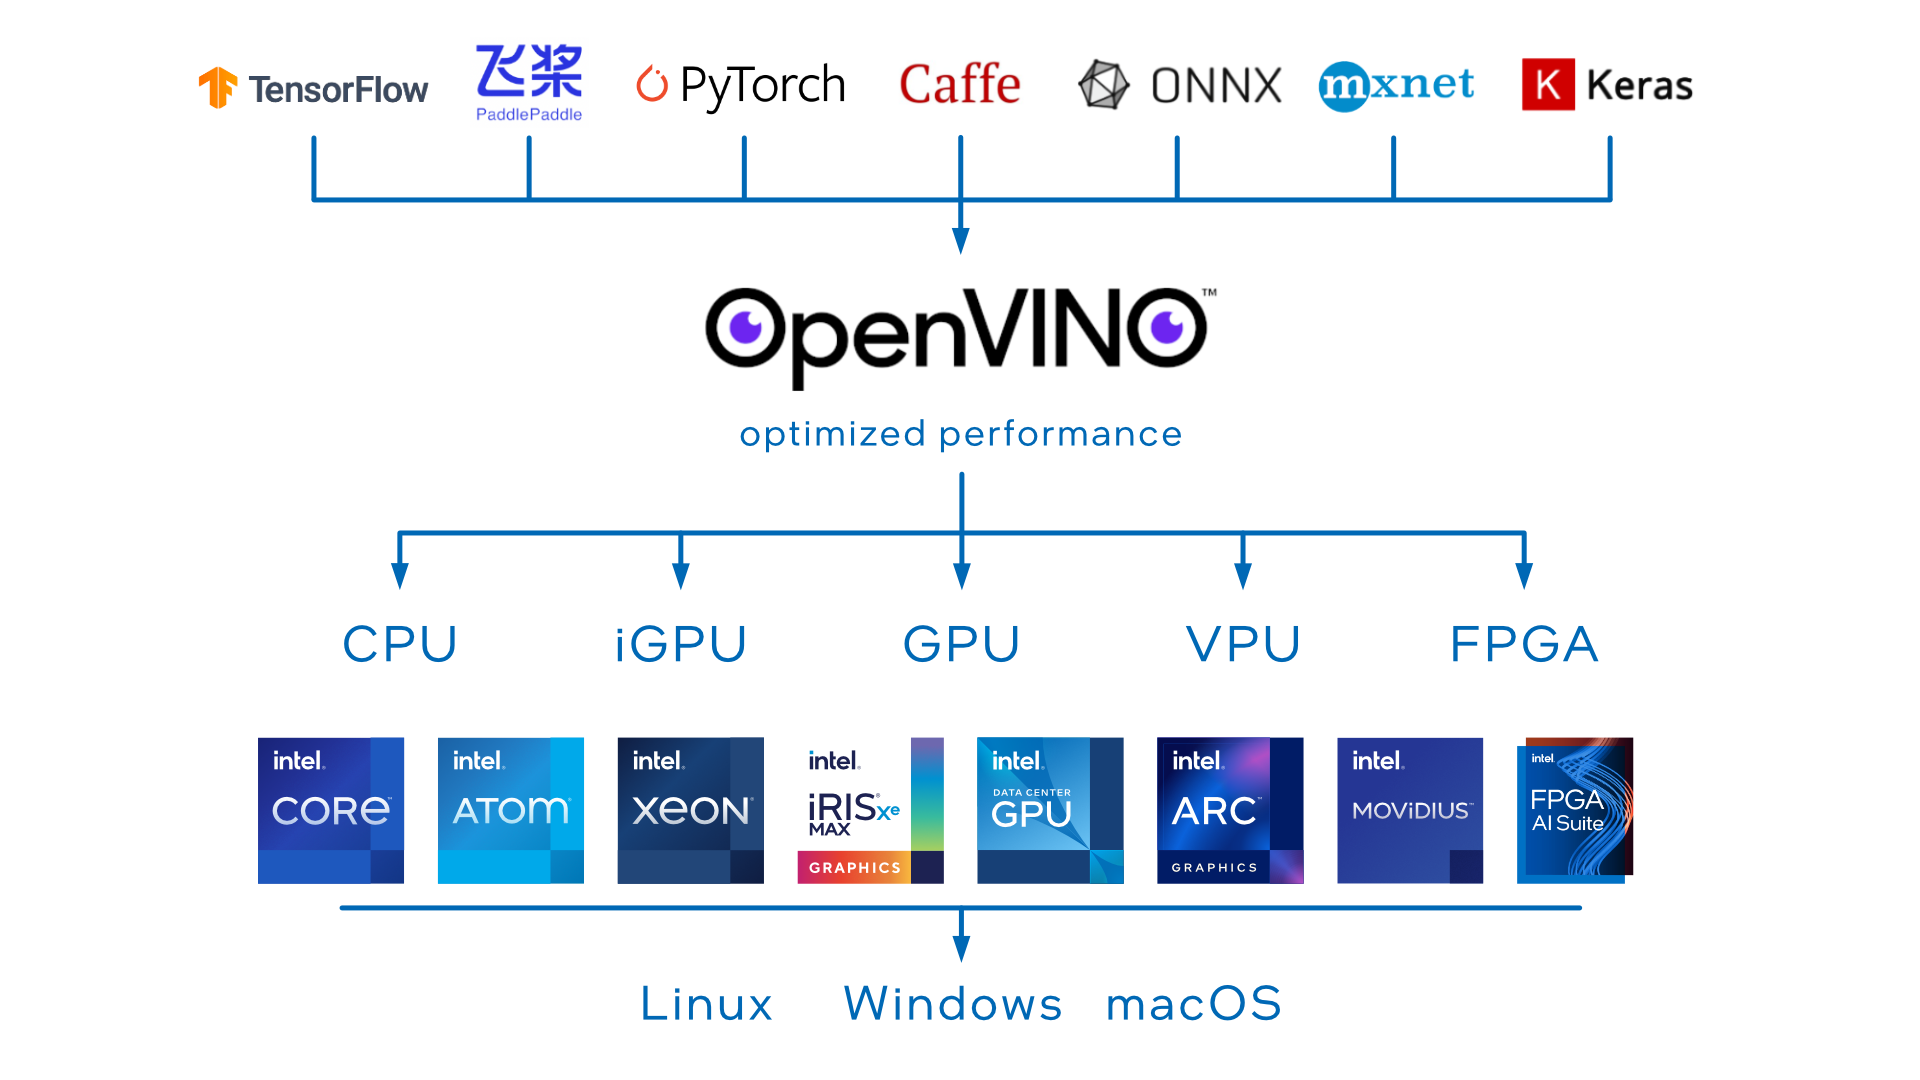
OpenVINO supports all the popular frameworks and model formats such as TensorFlow, PyTorch, Kera, MXnext & ONNX. Developers first train their models using these frameworks to create the resulting set of weights & biases that comprise the model. Once training is completed, the models weights can be loaded using openVINO can be quantized e.g. to inte 8 or FP16 to allow for better performance during inference, compiled to an intermediate representation (IR) which allows for any platform with OpenVINO inference engine to load, optimize and run the model. OpenVINO supports deploying a single IR to Core Ultra, ARC, GPU Max, NPU, Gaudi, Xeon & Altera FPGAs easily with OpenVINO handling all the platform specific optimizations.

## Object Detection Model
Object detection is a crucial task in computer vision that involves identifying and locating objects within an image or video. It combines two primary tasks: image classification and object localization. Face detection technology is often used for surveillance and tracking of people in real time.

The process first starts with an image that is fed into the model. 
The model extracts features from the images using convolutional layers.
The model generates region proposals, which are potential bounding boxes where objects may be located. 
Each region proposal is then classified to determine what kind of object it contains.
To eliminate redundant bounding boxes, the model applies Non-Maximum Suppression. This ensures that each object is represented by a single, most confident bounding box.


## Getting started
To get started please run the cell below, it will get everything ready for you to complete this notepad.

In [1]:
#The following installs the necessary python libraries to run this code
!pip install -q "openvino-dev>=2023.1.0"
!pip install -q tensorflow
!pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

print("Installation of packages has been satisfied!")

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\tensorboard\\data\\grpc_provider.py'
Consider using the `--user` option or check the permissions.



Installation of packages has been satisfied!


### Please run this cell to import all required modules that will be used.

In [ ]:
#the following are the necessary imports for this model to run
import collections
import tarfile
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
import openvino as ov
from openvino.tools.mo.front import tf as ov_tf_front
from openvino.tools import mo

import notebook_utils as utils

print("All packages have been imported!")

# A directory where the model will be downloaded.
base_model_dir = Path("model")

# The name of the model from Open Model Zoo
model_name = "ssdlite_mobilenet_v2"

archive_name = Path(f"{model_name}_coco_2018_05_09.tar.gz")
model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/public/2022.1/{model_name}/{archive_name}"

# Download the archive
downloaded_model_path = base_model_dir / archive_name
if not downloaded_model_path.exists():
    utils.download_file(model_url, downloaded_model_path.name, downloaded_model_path.parent)
    print("The model has been downloaded to path")

# Unpack the model
tf_model_path = base_model_dir / archive_name.with_suffix("").stem / "frozen_inference_graph.pb"
if not tf_model_path.exists():
    with tarfile.open(downloaded_model_path) as file:
        file.extractall(base_model_dir)


print("the model has been downloaded and unpacked!")

All packages have been imported!


model\ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

The model has been downloaded to path
the model has been downloaded and unpacked!


## Converting the model to OpenVINO IR
The next part of the code is where we load the model and convert it to the intermediate representation (IR) that OpenVINO uses. We also specify the precision we would like to use, in this case FP16. Once converted the model is then saved to disk.

Most hardware supports multiple floating point (FP) precisions or integer (Int) precisions e.g. int32, int8, int4 & int4 or MXFP8, FP16, BF16, TF32 ect... The precision and datatype used can have a large effect on performance as typically the logic to do lower precision operations is much smaller and thus there is much more of it in products meaning the work is done faster, this is typically why AI uses FP16 or int8. Its also important to note that precision will also effect the quality of output from the model.

**THIS MAY TAKE A FEW MINS**

In [ ]:
#the following will convert the TensorFlow formatted model to OpenVINO IR format:
#the Model Conversion API (mo.convert_model function) will be used 

precision = "FP16"
# The output path for the conversion.
converted_model_path = Path("model") / f"{model_name}_{precision.lower()}.xml"

# Convert it to IR if not previously converted
trans_config_path = Path(ov_tf_front.__file__).parent / "ssd_v2_support.json"
if not converted_model_path.exists():
    ov_model = mo.convert_model(
        tf_model_path,
        compress_to_fp16=(precision == 'FP16'),
        transformations_config=trans_config_path,
        tensorflow_object_detection_api_pipeline_config=tf_model_path.parent / "pipeline.config",
        reverse_input_channels=True
    )
    ov.save_model(ov_model, converted_model_path)
    del ov_model
print("\n\nModel successfully converted to OpenVINO IR")

[ INFO ] MO command line tool is considered as the legacy conversion API as of OpenVINO 2023.2 release.
In 2025.0 MO command line tool and openvino.tools.mo.convert_model() will be removed. Please use OpenVINO Model Converter (OVC) or openvino.convert_model(). OVC represents a lightweight alternative of MO and provides simplified model conversion API. 
Find more information about transition from MO to OVC at https://docs.openvino.ai/2023.2/openvino_docs_OV_Converter_UG_prepare_model_convert_model_MO_OVC_transition.html


[ WARNING ]  The Preprocessor block has been removed. Only nodes performing mean value subtraction and scaling (if applicable) are kept.


Model successfully converted to OpenVINO IR


## Selecting device to run inference on
The next thing to do is choose the target device, this can be anything from CPU, NPU, GPU or maybe even Gaudi if present. The code below creates a drop down to choose which device to use, play about with changing the device and re running inference to see how the device selected affects performance!

In [ ]:
#this code cell will load the model
#you can choose wether to run it on CPU or GPU when changing the value of
#'value', 'value' could be ('AUTO','GPU','CPU','NPU'), AUTO wil choose the best option

import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='GPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='GPU')

## Loading the model for inference
Now that we have converted the model to OpenVINO IR & selected which device to run the model on we now need to load the OpenVINO IR model up and get the input & output layers to get their shape & to input data into the model.

In [ ]:
# Read the network and corresponding weights from a file.
#this basically reads the pretrained model's data so we run it
model = core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = core.compile_model(model=model, device_name=device.value)

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Get the input size.
height, width = list(input_layer.shape)[1:3]

#Input and output layers have the names of the input node and output node
#respectively. In the case of SSDLite MobileNetV2, there is 1 input and 1 output.
input_layer.any_name, output_layer.any_name

('image_tensor:0', 'detection_boxes:0')

## Setup detectable objects & associated colours
The next code snippet just sets up a series of functions & associations to allow human understanding and visualisation of the models output. This consists of assigning a unique colour to each classified object & drawing boxes around them on the image.

In [ ]:
#We need to list all available classes and create colors for them
# this will alow us to then choose which objects we want to detect and
# which we want to ignore
# we can use the following to see what type of object detection classes
# are present within the dataset:
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
#here are some example classes:
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

#this defines the Colors for the classes above (Rainbow Color Map)
# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()

# this processes the results
#try changing the threshold and see what happens (should start ignoring/recognising objects based on probability)

def process_results(frame, results, thresh=0.6):
    # The size of the original frame.
    h, w = frame.shape[:2]
    # The 'results' variable is a [1, 1, 100, 7] tensor.
    results = results.squeeze()
    boxes = []
    labels = []
    scores = []
    for _, label, score, xmin, ymin, xmax, ymax in results:
        # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
        boxes.append(
            tuple(map(int, (xmin * w, ymin * h, (xmax - xmin) * w, (ymax - ymin) * h)))
        )
        labels.append(int(label))
        scores.append(float(score))
#the following implements the No Maximum Suppression threshold
#which allows a threshold depicting wether to show overlapping objects or not
# it is a sensitivity threshold
# change the value of the threshold to see how it changes object detection in overlapping
# objects


    # Apply non-maximum suppression to get rid of many overlapping entities.
    # See https://paperswithcode.com/method/non-maximum-suppression
    # This algorithm returns indices of objects to keep.
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=thresh, nms_threshold=0.6
    )

    # If there are no boxes.
    if len(indices) == 0:
        return []

    # Filter detected objects.
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]

# this method draws the boxes around the object:
def draw_boxes(frame, boxes):
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(img=frame, pt1=box[:2], pt2=(x2, y2), color=color, thickness=3)

        # Draw a label name inside the box.
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(box[0] + 10, box[1] + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

    return frame

## Running the model
The next bit of code sets up the window for visualisation and runs the model, here each frame of a video is loaded and ran through the model to detect the objects and labelling is applied and the result is subsequently visualised in a window below.

In [ ]:
# the following is the Main Processing Function
# the object detection can be run on either webcam or a specifc video input
# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]

            # Measure processing time.

            start_time = time.time()
            # Get the results.
            results = compiled_model([input_img])[output_layer]
            stop_time = time.time()
            # Get poses from network results.
            boxes = process_results(frame=frame, results=results)

            # Draw boxes on a frame.
            frame = draw_boxes(frame=frame, boxes=boxes)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## Running the model on a specific video input

The following code snippet allows you to edit the webcam setup. The webcan is only used when the code cell is being run locally on your device.

In [ ]:
# in order to use a webcam, the default webcam address is source=0
# the source depends on the number of webcams setup
# setting flip=True is necessary when using front webcam
# when experiencing flickering do: use_popup=True and that should fix it

# NOTE: the webcam will only work if you run on computer hardware and not on a 
# server such as (Binder). 

#the following shows how to run the model on a sepcific video input

USE_WEBCAM = False

#this is the video directory we are using
video_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"
#here are some other video sources to test out:
# a good practice is to change the threshold's above to fine tune the model for better object detection
#coco walking (current video above): https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4
#people: https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4
#intel video: https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Sheldon%20Cooper%20Jim%20Parsons%20at%20Intels%20Lab.mp4
cam_id = 0

source = cam_id if USE_WEBCAM else video_file

run_object_detection(source=source, flip=isinstance(source, int), use_popup=False)

NameError: name 'run_object_detection' is not defined